1. Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features. Use the data from 2005.

In [1]:
#libraries
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import getpass

In [2]:
password = getpass.getpass()

········


In [3]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'

engine = create_engine(connection_string)
query = '''SELECT f.film_id, r.inventory_id, f.rental_duration, f.rental_rate, f.rating
FROM film f
LEFT JOIN inventory i
ON i.film_id = f.film_id
LEFT JOIN rental r 
ON i.inventory_id = r.inventory_id
WHERE YEAR(rental_date) = 2005
;'''

data = pd.read_sql_query(query, engine)
data.head()

,film_id,inventory_id,rental_duration,rental_rate,rating
0,1,1,6,0.99,PG
1,1,1,6,0.99,PG
2,1,1,6,0.99,PG
3,1,2,6,0.99,PG
4,1,2,6,0.99,PG


though on using category_id and language_id
    language_id: only 1
    category_id: too many and no way to aggregate them

2. Create a query to get the total amount of rentals in June for each film.
Do the same with July.

In [4]:
query = '''SELECT fi.film_id, COALESCE(le.rental_jun,0) as rental_jun, COALESCE(ri.rental_jul,0) as rental_jul
FROM film fi
LEFT JOIN 

(
SELECT f.film_id, count(r.rental_id) as rental_jun
FROM film f
LEFT JOIN inventory i
ON f.film_id = i.film_id
LEFT JOIN rental r
ON i.inventory_id = r.inventory_id
WHERE MONTH(r.rental_date) =6 
GROUP BY f.film_id) le

ON fi.film_id = le.film_id

LEFT JOIN 

(
SELECT f.film_id, count(r.rental_id) as rental_jul
FROM film f
LEFT JOIN inventory i
ON f.film_id = i.film_id
LEFT JOIN rental r
ON i.inventory_id = r.inventory_id
WHERE MONTH(r.rental_date) =7 
GROUP BY f.film_id
ORDER BY f.film_id) ri

ON fi.film_id = ri.film_id;
'''

data_rental = pd.read_sql_query(query, engine)

3. Create a new column containing (Yes/No) for each film whether or not the number of monthly rentals in July was bigger than in June. Your objective will be to predict this new column.

In [5]:
data_agg = data.groupby('film_id').agg({'inventory_id':'count',
                                       'rental_duration':'max',
                                       'rental_rate':'max',
                                       'rating':'max'}).reset_index()

In [6]:
list_film = list(data_rental[data_rental.rental_jul > data_rental.rental_jun]['film_id'])

data_agg['yesno'] = data_agg['film_id'].apply(lambda x: 'Yes' if x in list_film else 'No')

4. Read the data into a Pandas dataframe.

In [7]:
data_agg

,film_id,inventory_id,rental_duration,rental_rate,rating,yesno
0,1,23,6,0.99,PG,Yes
1,2,6,3,4.99,G,Yes
2,3,12,7,2.99,NC-17,Yes
3,4,22,5,2.99,G,Yes
4,5,11,6,2.99,G,Yes
...,...,...,...,...,...,...
953,996,7,6,0.99,G,Yes
954,997,6,4,0.99,NC-17,Yes
955,998,8,6,0.99,NC-17,Yes
956,999,17,5,2.99,R,Yes


5. Analyze extracted features and transform them. You may need to encode some categorical variables or scale numerical variables.

In [8]:
data_agg.dtypes

film_id              int64
inventory_id         int64
rental_duration      int64
rental_rate        float64
rating              object
yesno               object
dtype: object

In [9]:
x = data_agg[['inventory_id','rental_duration','rental_rate','rating']]
y = data_agg['yesno']

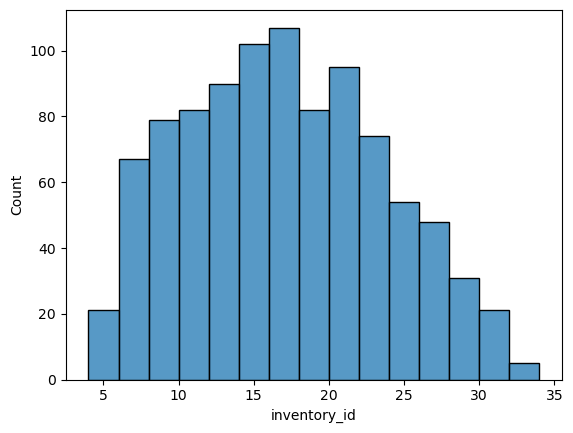

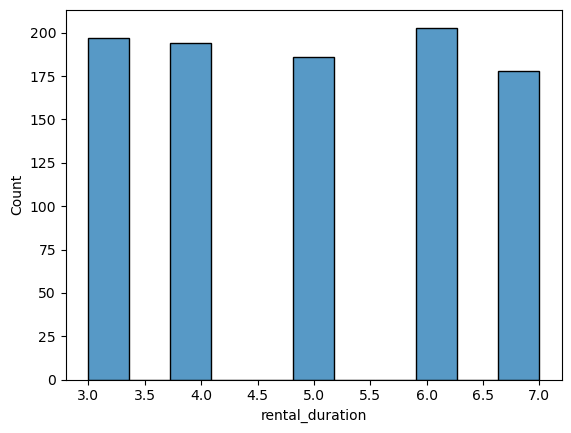

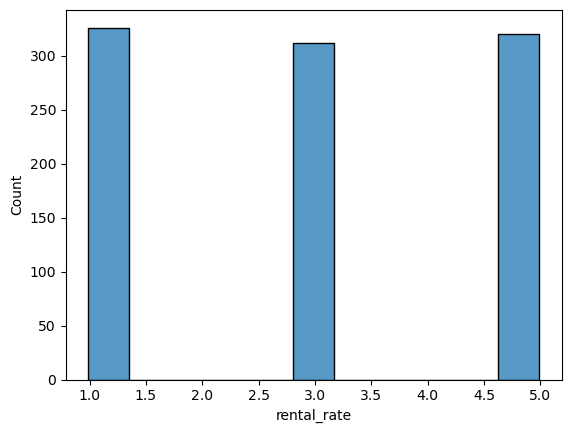

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_hist(df):
    list_of_ncolumns = list(df.select_dtypes(np.number))
    #list with numeric columns names
    for col in list_of_ncolumns:
        sns.histplot(df[col])
        plt.show()
        
plot_hist(x)

Distribution kinda looks normal, so only MinMaxScaler will be applied

In [11]:
data_agg['rating'].value_counts()

PG-13    213
NC-17    202
R        189
PG       183
G        171
Name: rating, dtype: int64

5 categories, similar frequencies, no change will be made

## Split x-y

In [12]:
from sklearn.model_selection import train_test_split

#split x_num, small dataset, I am diving 0.7:0,3
x_tr, x_te, y_tr, y_te = train_test_split(x, y, test_size=0.3, random_state=42)

## Split numerical-categorical

In [13]:
x_tr_n = x_tr.select_dtypes(np.number)
x_tr_c = x_tr.select_dtypes('object')
x_te_n = x_te.select_dtypes(np.number)
x_te_c = x_te.select_dtypes('object')

## Transforming

In [14]:
# Scaling numerical data
from sklearn.preprocessing import MinMaxScaler

transformer = MinMaxScaler().fit(x_tr_n)

#x_tr_norm = transformer.transform(x_tr_n)
#x_te_norm = transformer.transform(X_te_n)

x_tr_nnorm = pd.DataFrame(transformer.transform(x_tr_n), columns = x_tr_n.columns)
x_te_nnorm = pd.DataFrame(transformer.transform(x_te_n), columns = x_te_n.columns)

In [15]:
# Transforming categorical data
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(drop='first').fit(x_tr_c)

x_tr_c = encoder.transform(x_tr_c).toarray()
x_te_c = encoder.transform(x_te_c).toarray()

x_tr_c = pd.DataFrame(x_tr_c, columns = encoder.get_feature_names_out())
x_te_c = pd.DataFrame(x_te_c, columns = encoder.get_feature_names_out())

##Joining numerical-categorical

In [16]:
x_tr_f = np.concatenate([x_tr_nnorm, x_tr_c], axis=1)
x_te_f = np.concatenate([x_te_nnorm, x_te_c], axis=1)

6. Create a logistic regression model to predict this new column from the cleaned data.

In [19]:
from sklearn.linear_model import LogisticRegression

clas = LogisticRegression(random_state=0, solver='lbfgs',
                          max_iter=1000, multi_class='multinomial')

clas = clas.fit(x_tr_f, y_tr)


y_te_pr = clas.predict(x_te_f)
clas.score(x_te_f, y_te)

0.9965277777777778

7. Evaluate the results.

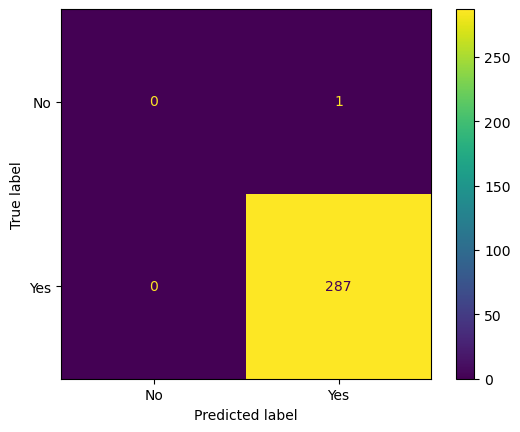

In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

conf_mat = confusion_matrix(y_te, y_te_pr)
ConfusionMatrixDisplay(conf_mat, display_labels=clas.classes_).plot()

In [28]:
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import classification_report

print("coher_kappa score is", cohen_kappa_score(y_te, y_te_pr))
print(classification_report(y_te, y_te_pr, zero_division = 0))

coher_kappa score is 0.0
              precision    recall  f1-score   support

          No       0.00      0.00      0.00         1
         Yes       1.00      1.00      1.00       287

    accuracy                           1.00       288
   macro avg       0.50      0.50      0.50       288
weighted avg       0.99      1.00      0.99       288



As data is overly imbalanced, model could not predict no, so cohen_kappa score is 0. Not a good model.